# 📘 Locally Weighted Regression (LWR)

## 📖 1. What Is Locally Weighted Regression?

**Locally Weighted Regression (LWR)** is a **non-parametric regression** technique that fits a **local model** to each test point using nearby training points, with weights decreasing with distance.

Also known as **LOESS** or **LOWESS** (Locally Estimated Scatterplot Smoothing), it's ideal for modeling **nonlinear relationships** with smooth trends.

---

## 🧠 Model Definition

To predict $ y $ at query point $ x_0 $, LWR solves:

$$
\hat{\boldsymbol{\beta}}(x_0) = \arg\min_{\boldsymbol{\beta}} \sum_{i=1}^{n} w_i(x_0) (y_i - \mathbf{x}_i^\top \boldsymbol{\beta})^2
$$

- $ w_i(x_0) = \exp\left( -\frac{\|x_i - x_0\|^2}{2\tau^2} \right) $ — Gaussian kernel
- $ \tau $ controls the **bandwidth** (locality)

---

## ⚙️ Key Properties

- Non-parametric and flexible
- Performs **weighted linear regression** locally
- Sensitive to choice of bandwidth \( \tau \)

---

## ✅ Use Cases

- Modeling smooth nonlinear relationships
- Small to medium datasets
- Visualization of trends





## Simulated data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
sns.set(style='whitegrid')

# Simulated data
np.random.seed(0)
X = np.linspace(0, 1, 200).reshape(-1, 1)
y_true = np.sin(2 * np.pi * X).ravel()
y = y_true + np.random.normal(0, 0.1, size=len(X))

In [2]:
# Locally Weighted Regression function
def locally_weighted_regression(X_train, y_train, x0, tau):
    weights = np.exp(-np.square(X_train - x0) / (2 * tau ** 2))
    W = np.diagflat(weights)
    X_ = np.hstack((np.ones_like(X_train), X_train))
    x0_ = np.array([1, x0])
    beta = np.linalg.pinv(X_.T @ W @ X_) @ X_.T @ W @ y_train
    return x0_ @ beta

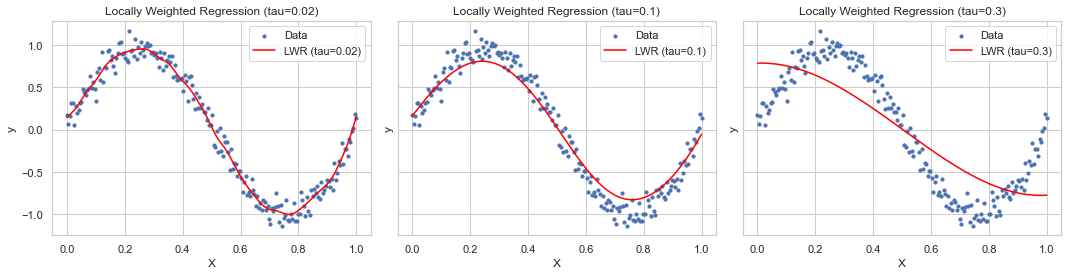

In [3]:
# Apply to entire dataset for different taus
taus = [0.02, 0.1, 0.3]
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
for i, tau in enumerate(taus):
    y_hat = np.array([locally_weighted_regression(X, y, x0, tau) for x0 in X.ravel()])
    axes[i].scatter(X, y, s=10, label='Data')
    axes[i].plot(X, y_hat, color='red', label=f'LWR (tau={tau})')
    axes[i].set_title(f"Locally Weighted Regression (tau={tau})")
    axes[i].set_xlabel("X")
    axes[i].set_ylabel("y")
    axes[i].legend()
plt.tight_layout()
plt.show()

## 🏠 Real Data: California Housing (Single Feature)

In [6]:
from sklearn.datasets import fetch_california_housing

# Load data
cal = fetch_california_housing()
X_real = cal.data[:, [0]]  # MedInc
y_real = cal.target
# Subsample: use only 300 points for demo
np.random.seed(0)
sample_idx = np.random.choice(len(X_real), size=300, replace=False)
X_real_small = X_real[sample_idx]
y_real_small = y_real[sample_idx]


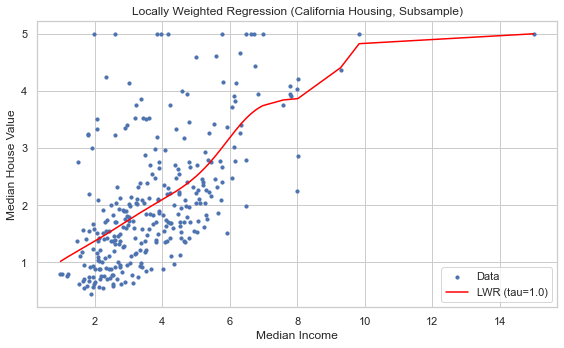

In [7]:
# Sort by X for plotting
# Sort and apply LWR
sort_idx = np.argsort(X_real_small.ravel())
X_sorted = X_real_small[sort_idx]
y_sorted = y_real_small[sort_idx]

y_hat_real = np.array([
    locally_weighted_regression(X_real_small, y_real_small, x0, tau=1.0)
    for x0 in X_sorted.ravel()
])

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(X_sorted, y_sorted, s=10, label='Data')
plt.plot(X_sorted, y_hat_real, color='red', label='LWR (tau=1.0)')
plt.xlabel("Median Income")
plt.ylabel("Median House Value")
plt.title("Locally Weighted Regression (California Housing, Subsample)")
plt.legend()
plt.tight_layout()
plt.show()


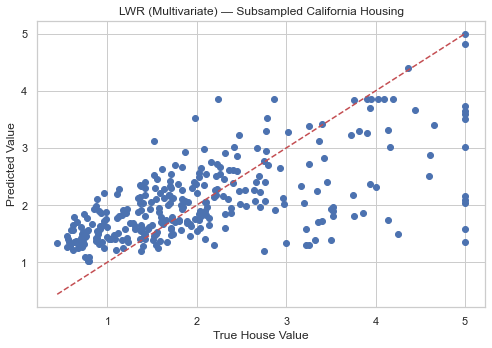

In [9]:
plt.figure(figsize=(7, 5))
plt.scatter(y_sorted, y_hat_real)
plt.plot([y_sorted.min(), y_sorted.max()], [y_sorted.min(), y_sorted.max()], 'r--')
plt.xlabel("True House Value")
plt.ylabel("Predicted Value")
plt.title("LWR (Multivariate) — Subsampled California Housing")
plt.tight_layout()
plt.show()

LWR (tau=0.5) - MSE on sample: 0.0500


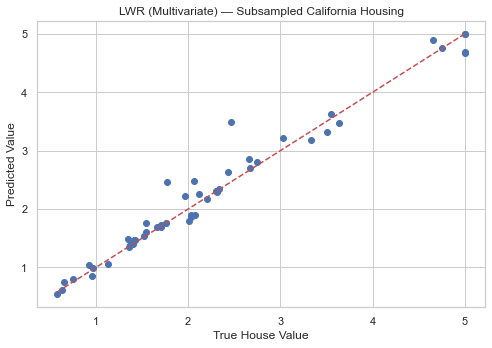

In [8]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load and preprocess data
data = fetch_california_housing()
X = data.data
y = data.target
scaler = StandardScaler()

# ✅ Subsample the training set for speed
np.random.seed(0)
subsample_idx = np.random.choice(len(X), size=500, replace=False)
X_sub = X[subsample_idx]
y_sub = y[subsample_idx]

X_sub_scaled = scaler.fit_transform(X_sub)

# Define the LWR function
def locally_weighted_regression_multivariate(X_train, y_train, x0, tau):
    distances = np.linalg.norm(X_train - x0, axis=1)
    weights = np.exp(-distances**2 / (2 * tau**2))
    W = np.diag(weights)
    X_aug = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
    x0_aug = np.hstack(([1], x0))
    beta = np.linalg.pinv(X_aug.T @ W @ X_aug) @ X_aug.T @ W @ y_train
    return x0_aug @ beta

# ✅ Predict on a few test points (also from the small sample)
np.random.seed(42)
sample_indices = np.random.choice(X_sub_scaled.shape[0], size=50, replace=False)
X_sample = X_sub_scaled[sample_indices]
y_sample = y_sub[sample_indices]

# Predict using LWR
tau = 0.5
y_pred = np.array([
    locally_weighted_regression_multivariate(X_sub_scaled, y_sub, x0, tau)
    for x0 in X_sample
])

# Evaluate
mse = mean_squared_error(y_sample, y_pred)
print(f"LWR (tau={tau}) - MSE on sample: {mse:.4f}")

# Plot predicted vs. true
plt.figure(figsize=(7, 5))
plt.scatter(y_sample, y_pred)
plt.plot([y_sample.min(), y_sample.max()], [y_sample.min(), y_sample.max()], 'r--')
plt.xlabel("True House Value")
plt.ylabel("Predicted Value")
plt.title("LWR (Multivariate) — Subsampled California Housing")
plt.tight_layout()
plt.show()

